In [1]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

%matplotlib inline


# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

rcParams['figure.figsize'] = 15, 6

#ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima import auto_arima

from prophet import Prophet

from pandas import to_datetime




import itertools
import warnings

from datetime import datetime
from datetime import timedelta
from datetime import datetime
warnings.filterwarnings('ignore')


In [2]:
# from google.colab import files

# # Upload CSV file
# uploaded = files.upload()

In [3]:
data = pd.read_csv("crime-per-county.csv")

data.head()

STATISTIC Label Quarter                 Garda Division  \
0  Recorded crime incidents  2003Q1  Cavan/Monaghan Garda Division   
1  Recorded crime incidents  2003Q1  Cavan/Monaghan Garda Division   
2  Recorded crime incidents  2003Q1  Cavan/Monaghan Garda Division   
3  Recorded crime incidents  2003Q1  Cavan/Monaghan Garda Division   
4  Recorded crime incidents  2003Q1  Cavan/Monaghan Garda Division   

                      Type of Offence    UNIT  VALUE  
0                   Homicide offences  Number    1.0  
1                              Murder  Number    0.0  
2                        Manslaughter  Number    0.0  
3                         Infanticide  Number    0.0  
4  Dangerous driving leading to death  Number    1.0

In [4]:
data.drop(columns =["STATISTIC Label", "UNIT"], inplace=True)

In [5]:
data['VALUE'] = data['VALUE'].fillna(0)
data['VALUE'] = data['VALUE'].astype('int64')

In [6]:
def quarter_to_date(year_quarter):
    year, quarter = year_quarter.split('Q')
    first_month = {'1': '01', '2' : '04' , '3' : '07' , '4' : '10'}
    return f"{year}-{first_month[quarter]}-1"

data['Date'] = data['Quarter'].apply(quarter_to_date)

In [7]:
# Correct way using .loc to avoid SettingWithCopyWarning
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

In [8]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [9]:
# Removing "Garda Division" from each entry
data['Garda Division'] = data['Garda Division'].str.replace(" Garda Division", "")

In [10]:
data.drop(columns =['Quarter'], inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166992 entries, 2003-01-01 to 2023-10-01
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Garda Division   166992 non-null  object
 1   Type of Offence  166992 non-null  object
 2   VALUE            166992 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.1+ MB


In [12]:
data.rename(columns = {'Type of Offence': 'Offence', 'VALUE': 'Crime'}, inplace=True)

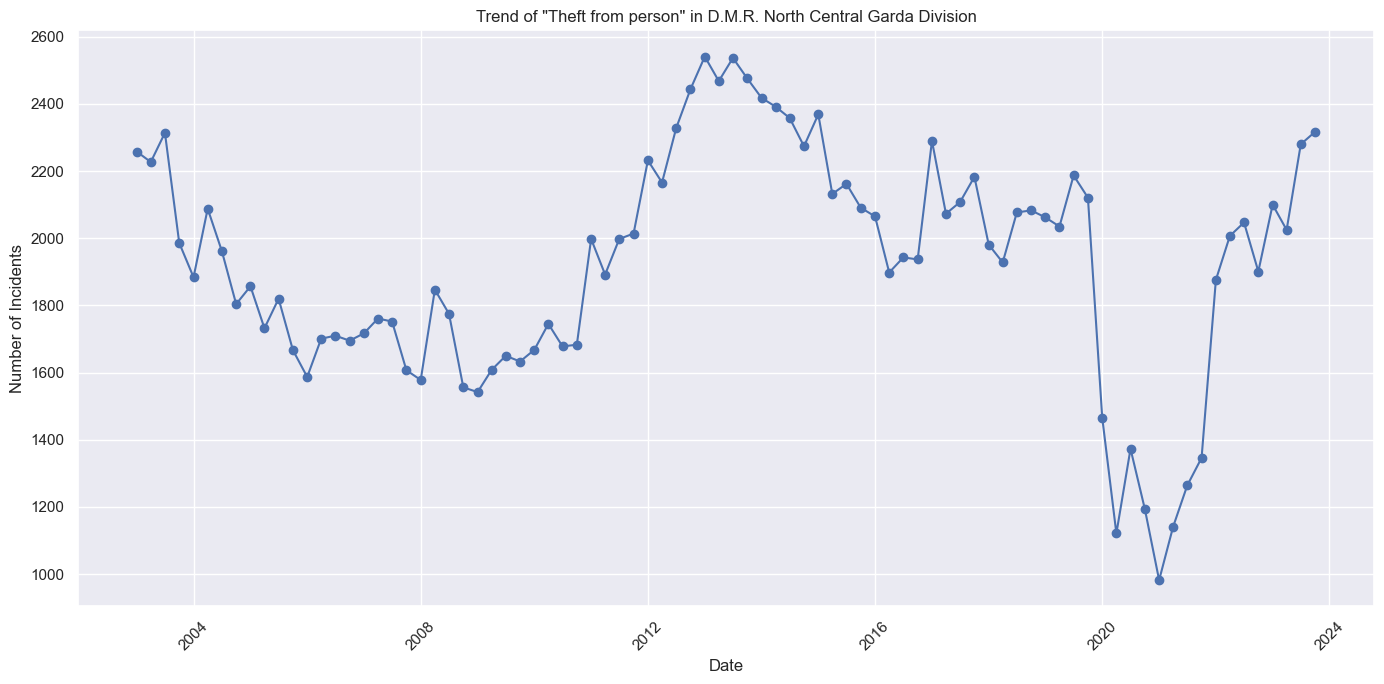

In [13]:
# Filter the data for "Theft from person" crimes in "D.M.R. North Central Garda Division"
theft_from_person_data = data[
    (data['Offence'] == 'Theft and related offences') &
    (data['Garda Division'] == 'D.M.R. South Central')
]


# Pivot to get a time series of "Theft from person" crimes for D.M.R. North Central Garda Division
theft_from_person_time_series = theft_from_person_data.pivot_table(values='Crime', index='Date', aggfunc='sum')

# Plotting the line graph
plt.figure(figsize=(14, 7))
plt.plot(theft_from_person_time_series.index, theft_from_person_time_series['Crime'], marker='o', linestyle='-', color='b')
plt.title('Trend of "Theft from person" in D.M.R. North Central Garda Division')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

In [14]:
#theft_from_person_data = theft_from_person_data.rename(columns = {'Crime' : 'y'})
#theft_from_person_data
theft_from_person_data.drop(columns =['Garda Division', 'Offence'], inplace=True)

In [15]:
train = theft_from_person_data.loc[: '2017-10-01']
test = theft_from_person_data.loc['2018-01-01':'2019-10-01']

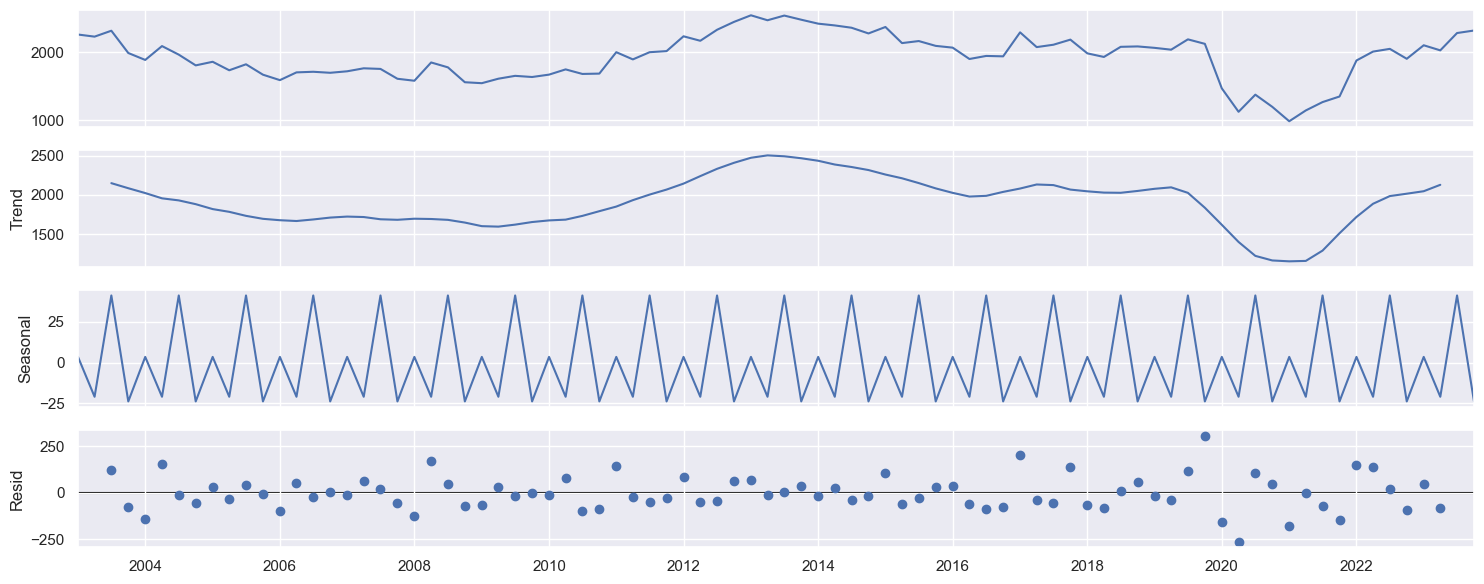

In [16]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(theft_from_person_data, model='additive')

# Plot the decomposed components
decomposition.plot()
plt.show()

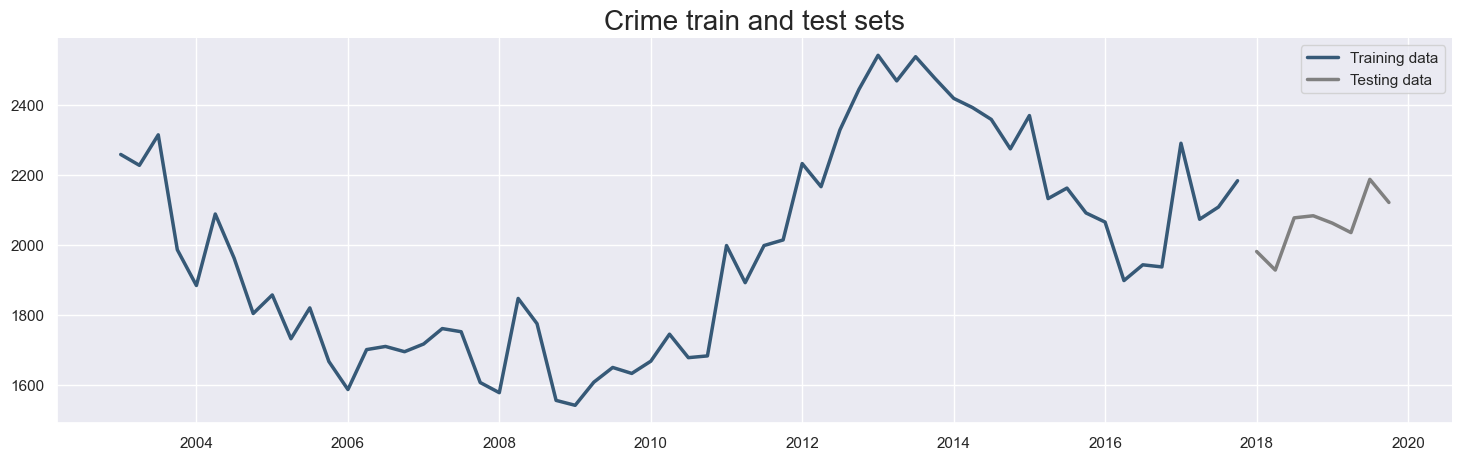

In [18]:
# Plot
plt.title('Crime train and test sets', size=20)
plt.plot(train['Crime'], label='Training data')
plt.plot(test['Crime'], color='gray', label='Testing data')
plt.legend();

In [20]:
def tes_optimizer(train, test, abg, trend_mode='add', seasonal_mode = 'add', seasonal_period=4,step=8):
    """This function to optimize hyperparameters for the TES model

    Args:
        train (pd.Series): train dataset
        test (pd.Series): test dataset
        abg (list): a tuple list that holds tuple of alpha, beta, gamma values
        trend_mode (str, optional): 'add' || 'mul' . Is the trend additive or multiplying? Defaults to 'add'.
        seasonal_mode (str, optional): 'add' || 'mul' . Is the seasonality additive or multiplying?. Defaults to 'add'.
        seasonal_period (int, optional): Step number that evaluates for the seasonal period. Defaults to 12.
        step (int, optional): How many steps later will the model that created with the train dataset forecast?. Defaults to 48.

    Returns:
        [float, float, float, float]: best_alpha, best_beta, best_gamma, best_mae
    """
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")

    for comb in abg: # visit the each combination
        tes_model = ExponentialSmoothing(train, trend=trend_mode, seasonal=seasonal_mode, seasonal_periods=seasonal_period).\
            fit(smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2]) # 0: alpha, 1: beta, 2: gamma. Creates a new TES instance by using each combination
        y_pred = tes_model.forecast(step) # forecast the `step` step later by using the TES instance
        mae = mean_absolute_error(test, y_pred) # calculate the MAE (mean absolute error)
        if mae < best_mae: # mark the best parameters
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [21]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)

In [22]:
print("Alphas: {}\nBetas: {}\nGammas: {}".format(alphas, betas, gammas))

Alphas: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Betas: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Gammas: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [23]:
abg = list(itertools.product(alphas, betas, gammas)) # Creating combinations of the 3 lists

In [24]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train,test, abg)

[0.1, 0.1, 0.1, 183.88]
[0.1, 0.1, 0.2, 126.68]
[0.1, 0.1, 0.3, 102.84]
[0.1, 0.1, 0.4, 97.36]
[0.1, 0.1, 0.5, 102.73]
[0.1, 0.1, 0.6, 111.11]
[0.1, 0.1, 0.7, 121.64]
[0.1, 0.1, 0.8, 133.73]
[0.1, 0.1, 0.9, 147.02]
[0.1, 0.2, 0.1, 125.91]
[0.1, 0.2, 0.2, 119.82]
[0.1, 0.2, 0.3, 118.03]
[0.1, 0.2, 0.4, 114.87]
[0.1, 0.2, 0.5, 111.73]
[0.1, 0.2, 0.6, 109.82]
[0.1, 0.2, 0.7, 121.1]
[0.1, 0.2, 0.8, 134.04]
[0.1, 0.2, 0.9, 147.9]
[0.1, 0.3, 0.1, 286.91]
[0.1, 0.3, 0.2, 240.38]
[0.1, 0.3, 0.3, 194.8]
[0.1, 0.3, 0.4, 153.2]
[0.1, 0.3, 0.5, 135.33]
[0.1, 0.3, 0.6, 124.57]
[0.1, 0.3, 0.7, 120.24]
[0.1, 0.3, 0.8, 134.46]
[0.1, 0.3, 0.9, 149.13]
[0.1, 0.4, 0.1, 395.95]
[0.1, 0.4, 0.2, 306.02]
[0.1, 0.4, 0.3, 229.45]
[0.1, 0.4, 0.4, 171.02]
[0.1, 0.4, 0.5, 135.99]
[0.1, 0.4, 0.6, 122.93]
[0.1, 0.4, 0.7, 119.7]
[0.1, 0.4, 0.8, 135.02]
[0.1, 0.4, 0.9, 150.43]
[0.1, 0.5, 0.1, 390.8]
[0.1, 0.5, 0.2, 285.41]
[0.1, 0.5, 0.3, 195.84]
[0.1, 0.5, 0.4, 136.3]
[0.1, 0.5, 0.5, 115.05]
[0.1, 0.5, 0.6, 104.94]


[0.5, 0.4, 0.8, 270.83]
[0.5, 0.4, 0.9, 218.37]
[0.5, 0.5, 0.1, 312.95]
[0.5, 0.5, 0.2, 305.92]
[0.5, 0.5, 0.3, 301.59]
[0.5, 0.5, 0.4, 293.53]
[0.5, 0.5, 0.5, 285.96]
[0.5, 0.5, 0.6, 285.01]
[0.5, 0.5, 0.7, 286.04]
[0.5, 0.5, 0.8, 252.78]
[0.5, 0.5, 0.9, 177.97]
[0.5, 0.6, 0.1, 308.07]
[0.5, 0.6, 0.2, 297.93]
[0.5, 0.6, 0.3, 290.15]
[0.5, 0.6, 0.4, 277.77]
[0.5, 0.6, 0.5, 267.56]
[0.5, 0.6, 0.6, 269.55]
[0.5, 0.6, 0.7, 271.59]
[0.5, 0.6, 0.8, 198.56]
[0.5, 0.6, 0.9, 191.84]
[0.5, 0.7, 0.1, 280.83]
[0.5, 0.7, 0.2, 268.12]
[0.5, 0.7, 0.3, 257.32]
[0.5, 0.7, 0.4, 240.88]
[0.5, 0.7, 0.5, 230.03]
[0.5, 0.7, 0.6, 243.12]
[0.5, 0.7, 0.7, 256.49]
[0.5, 0.7, 0.8, 148.41]
[0.5, 0.7, 0.9, 210.34]
[0.5, 0.8, 0.1, 236.66]
[0.5, 0.8, 0.2, 222.56]
[0.5, 0.8, 0.3, 209.31]
[0.5, 0.8, 0.4, 188.71]
[0.5, 0.8, 0.5, 186.16]
[0.5, 0.8, 0.6, 224.31]
[0.5, 0.8, 0.7, 281.13]
[0.5, 0.8, 0.8, 150.8]
[0.5, 0.8, 0.9, 155.02]
[0.5, 0.9, 0.1, 181.38]
[0.5, 0.9, 0.2, 167.31]
[0.5, 0.9, 0.3, 155.48]
[0.5, 0.9, 0.4, 1

[0.9, 0.8, 0.6, 226.15]
[0.9, 0.8, 0.7, 267.12]
[0.9, 0.8, 0.8, 251.4]
[0.9, 0.8, 0.9, 269.99]
[0.9, 0.9, 0.1, 360.57]
[0.9, 0.9, 0.2, 299.18]
[0.9, 0.9, 0.3, 343.37]
[0.9, 0.9, 0.4, 368.66]
[0.9, 0.9, 0.5, 275.0]
[0.9, 0.9, 0.6, 264.48]
[0.9, 0.9, 0.7, 291.99]
[0.9, 0.9, 0.8, 274.62]
[0.9, 0.9, 0.9, 295.74]
best_alpha: 0.1 best_beta: 0.7 best_gamma: 0.3 best_mae: 55.3832


# Triple Exponential Smoothing (Holt-Winters)

In [25]:
final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=4).\
            fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma) # Creating the final tes model by using the best hyperparameters

y_pred = final_tes_model.forecast(8)

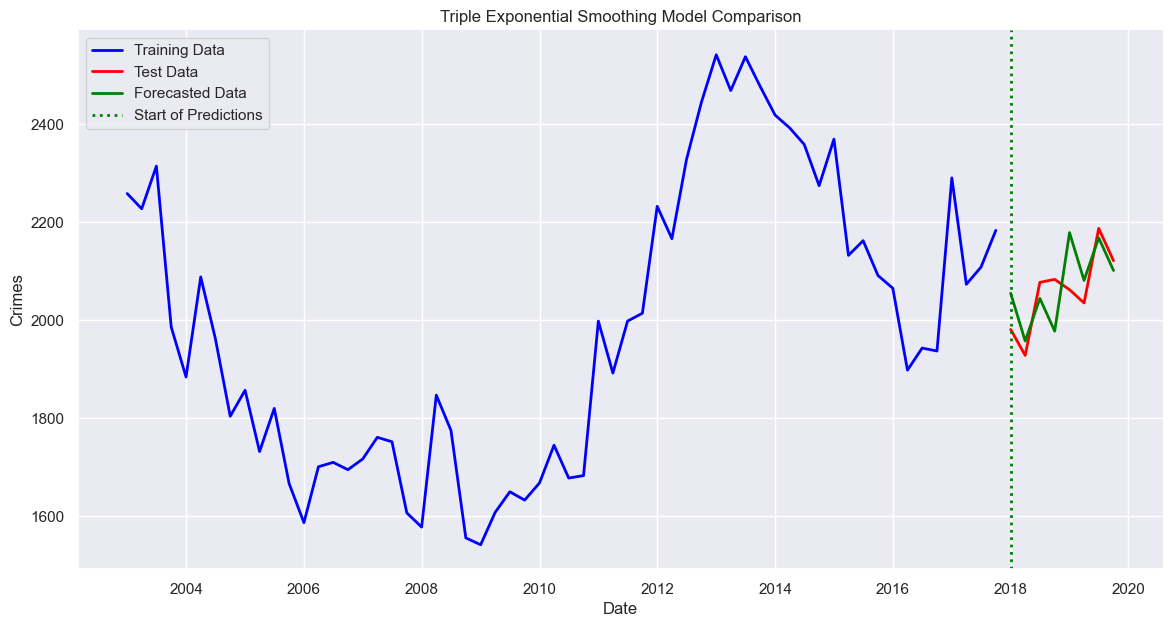

In [26]:
# Set figure size similar to the provided plot
plt.figure(figsize=(14, 7))


# Plotting training data
plt.plot(train, label='Training Data', linewidth=2, color='blue')  
# Plotting test data
plt.plot(test.index, test, label='Test Data', linewidth=2,  color='red')  
# Plotting forecasted data
plt.plot(y_pred, label='Forecasted Data', linewidth=2, color='green')



# Adding a vertical line to indicate the start of predictions
plt.axvline(x=test.index[0], color='green', linestyle=':', linewidth=2, label='Start of Predictions')

# Adding titles and labels
plt.title('Triple Exponential Smoothing Model Comparison')
plt.xlabel('Date')
plt.ylabel('Crimes')  # Adjust label according to the data context
plt.legend()
plt.grid(True)  # Enabling grid for better visualization
plt.show()

In [27]:
# Calculate RMSE
rmse = np.sqrt(((y_pred - test['Crime']) ** 2).mean())
mae = mean_absolute_error(test, y_pred)
mape = np.mean(np.abs((test['Crime'] - y_pred) / test['Crime'])) * 100
# Calculate the R² score
r2 = r2_score(test, y_pred)

print('MAE:', round(mae, 2))
print('RMSE:', round(rmse, 2))
print('MAPE:', round(mape, 2), '%')
print(f'R² score: {r2}')

MAE: 55.38
RMSE: 66.1
MAPE: 2.7 %
R² score: 0.2225501704866265
